In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/ECG_Image_data.zip" -d "/content/extracted"


Streaming output truncated to the last 5000 lines.
  inflating: /content/extracted/ECG_Image_data/train/V/V1869.png  
  inflating: /content/extracted/ECG_Image_data/train/V/V187.png  
  inflating: /content/extracted/ECG_Image_data/train/V/V1870.png  
  inflating: /content/extracted/ECG_Image_data/train/V/V1871.png  
  inflating: /content/extracted/ECG_Image_data/train/V/V1872.png  
  inflating: /content/extracted/ECG_Image_data/train/V/V1874.png  
  inflating: /content/extracted/ECG_Image_data/train/V/V1877.png  
  inflating: /content/extracted/ECG_Image_data/train/V/V1879.png  
  inflating: /content/extracted/ECG_Image_data/train/V/V188.png  
  inflating: /content/extracted/ECG_Image_data/train/V/V1880.png  
  inflating: /content/extracted/ECG_Image_data/train/V/V1881.png  
  inflating: /content/extracted/ECG_Image_data/train/V/V1882.png  
  inflating: /content/extracted/ECG_Image_data/train/V/V1883.png  
  inflating: /content/extracted/ECG_Image_data/train/V/V1884.png  
  inflating: 

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define dataset paths
train_path = "/content/extracted/ECG_Image_data/train"
test_path = "/content/extracted/ECG_Image_data/test"

# Define parameters
image_size = (224, 224)
batch_size = 32

# Function to remove noise using Gaussian Blur
def remove_noise(image):
    """ Apply Gaussian Blur to reduce noise in images """
    image = cv2.GaussianBlur(image, (5, 5), 0)  # (5,5) is the kernel size
    return image

# Custom preprocessing function for ImageDataGenerator
def preprocess_function(image):
    """ Convert image to numpy array, remove noise, and normalize """
    image = np.array(image)  # Convert to NumPy array
    image = remove_noise(image)  # Apply noise removal
    image = image / 255.0  # Normalize pixel values
    return image

# Create ImageDataGenerators for training and validation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_function,  # Apply noise removal
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_function  # Only apply noise removal & normalization
)

# Load training and test datasets from directories
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 99199 images belonging to 6 classes.
Found 24799 images belonging to 6 classes.


Training Data Class Distribution:
V: 5789 images
F: 642 images
S: 2223 images
N: 75709 images
Q: 6431 images
M: 8405 images

Test Data Class Distribution:
V: 1447 images
F: 161 images
S: 556 images
N: 18926 images
Q: 1608 images
M: 2101 images


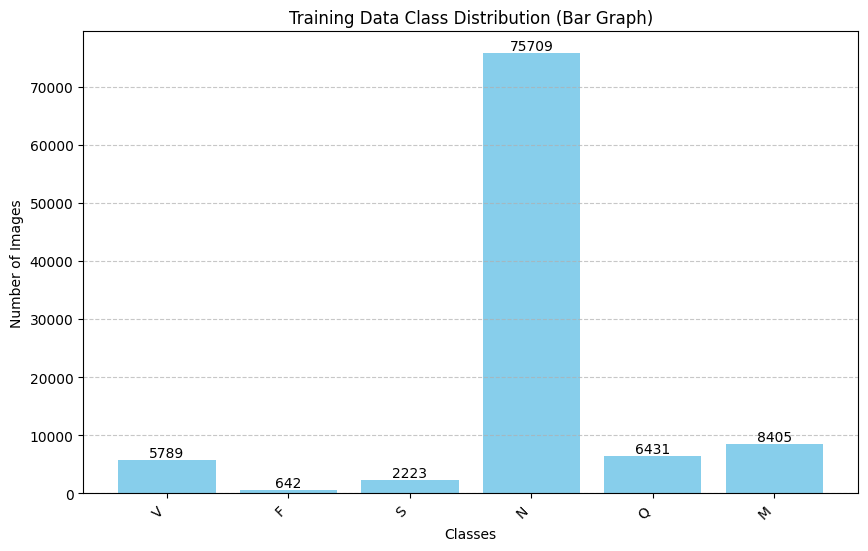

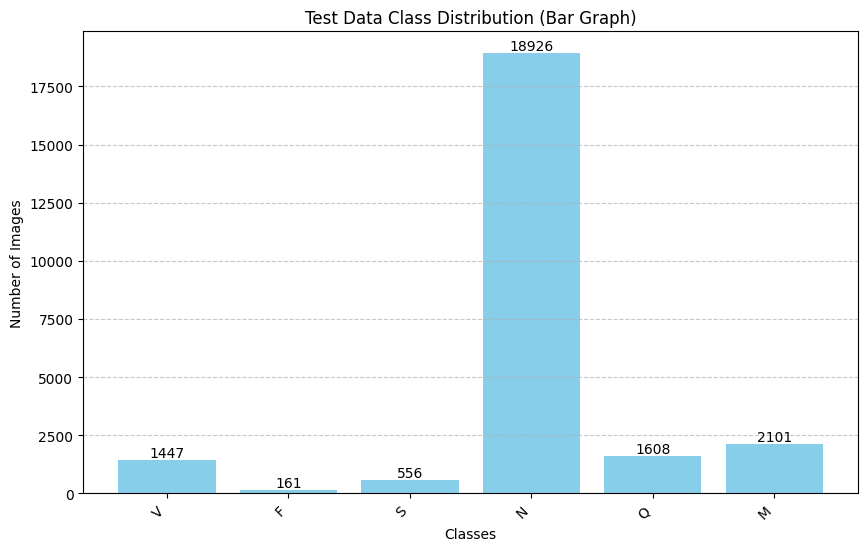

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

# Function to count images in each class
def count_images_in_class(directory_path):
    class_counts = {}
    for class_name in os.listdir(directory_path):
        class_path = os.path.join(directory_path, class_name)
        if os.path.isdir(class_path):
            image_count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[class_name] = image_count
    return class_counts

# Check class distribution for train and test data
train_class_counts = count_images_in_class(train_path)
test_class_counts = count_images_in_class(test_path)

# Print the class distribution
print("Training Data Class Distribution:")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count} images")

print("\nTest Data Class Distribution:")
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count} images")

# Function to visualize class distribution using Bar Graph
def plot_class_distribution_bar(class_counts, title):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    bars = plt.bar(classes, counts, color='skyblue')
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  # Rotate x labels for better visibility
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add text labels on top of bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval}', ha='center', va='bottom')

    plt.show()

# Plot bar chart for training and test data distributions
plot_class_distribution_bar(train_class_counts, "Training Data Class Distribution (Bar Graph)")
plot_class_distribution_bar(test_class_counts, "Test Data Class Distribution (Bar Graph)")


Training Data Class Weights:
Q: 2.5709
S: 7.4373
V: 2.8560
N: 0.2184
F: 25.7526
M: 1.9671


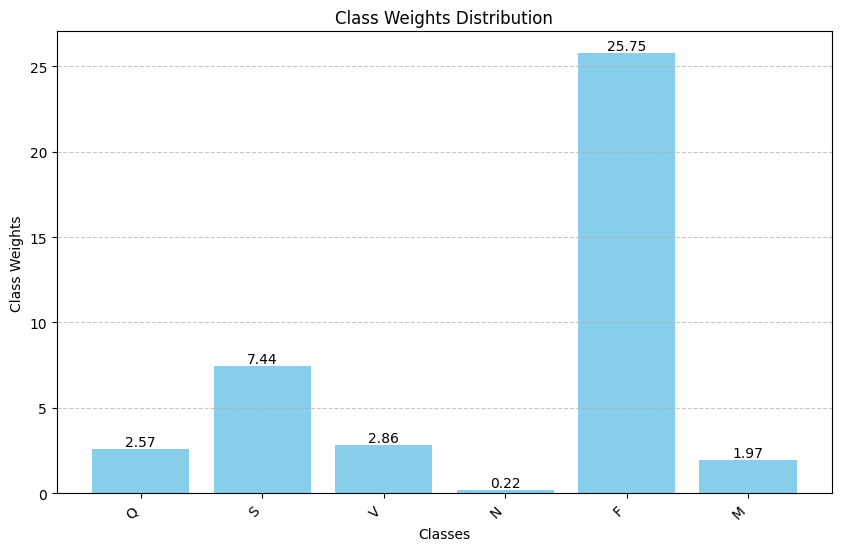

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

# Define class labels and image counts
train_class_counts = {'Q': 6431, 'S': 2223, 'V': 5789, 'N': 75709, 'F': 642, 'M': 8405}

# Compute class weights
class_labels = np.array(list(train_class_counts.keys()))
class_counts = np.array(list(train_class_counts.values()))

class_weights_dict = compute_class_weight(
    class_weight="balanced",
    classes=class_labels,
    y=np.repeat(class_labels, class_counts)
)

# Convert to dictionary format
class_weights = {class_labels[i]: class_weights_dict[i] for i in range(len(class_labels))}

# Print class weights in the specified format
print("Training Data Class Weights:")
for label, weight in class_weights.items():
    print(f"{label}: {weight:.4f}")  # Adjust decimal places as needed

# Function to visualize class weights using a bar graph
def plot_class_weights_bar(class_weights):
    classes = list(class_weights.keys())
    weights = list(class_weights.values())

    plt.figure(figsize=(10, 6))
    bars = plt.bar(classes, weights, color='skyblue')
    plt.xlabel("Classes")
    plt.ylabel("Class Weights")
    plt.title("Class Weights Distribution")
    plt.xticks(rotation=45, ha='right')  # Rotate x labels for better visibility
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add text labels on top of bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

    plt.show()

# Plot class weights using a bar graph
plot_class_weights_bar(class_weights)


Processing Dataset: 100%|██████████| 6/6 [01:08<00:00, 11.47s/it]


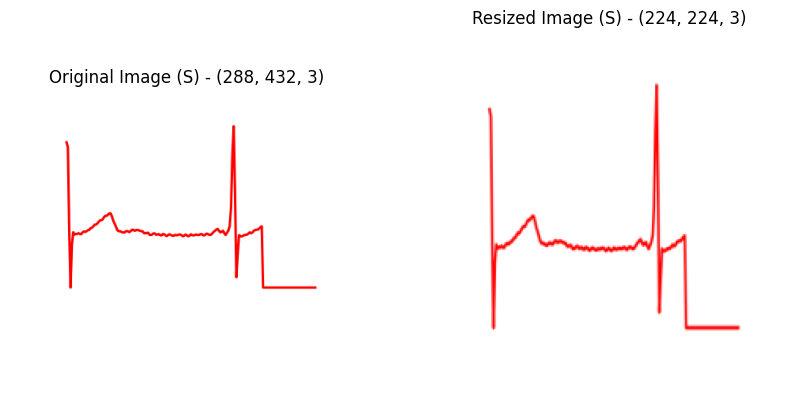


Training Data Processed Counts:
V: 5789 images
F: 642 images
S: 2223 images
N: 75709 images
Q: 6431 images
M: 8405 images

Test Data Processed Counts:
V: 1447 images
F: 161 images
S: 556 images
N: 18926 images
Q: 1608 images
M: 2101 images


In [ ]:
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bar

# Define dataset paths
train_path = "/content/extracted/ECG_Image_data/train"
test_path = "/content/extracted/ECG_Image_data/test"

# Define target image size
image_size = (224, 224)

# Function to resize images
def resize_image(image, size=(224, 224)):
    return cv2.resize(image, size, interpolation=cv2.INTER_AREA)

# Function to process all images in a dataset folder (only resizing)
def process_dataset(dataset_path):
    processed_images = {}  # Store processed image counts per class

    for class_name in tqdm(os.listdir(dataset_path), desc="Processing Dataset"):
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_path):
            continue  # Skip if it's not a directory

        processed_images[class_name] = 0  # Initialize count for class

        for image_name in os.listdir(class_path):
            if not image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue  # Skip non-image files

            image_path = os.path.join(class_path, image_name)
            image = cv2.imread(image_path)

            if image is None:
                continue  # Skip if image cannot be read

            # Apply resizing
            image = resize_image(image, image_size)

            processed_images[class_name] += 1  # Increment count

    return processed_images

# Process training and test datasets
train_processed_counts = process_dataset(train_path)
test_processed_counts = process_dataset(test_path)

# Pick one random image to show before and after
random_class = random.choice(list(train_processed_counts.keys()))
random_class_path = os.path.join(train_path, random_class)
random_image_name = random.choice([f for f in os.listdir(random_class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
random_image_path = os.path.join(random_class_path, random_image_name)

# Load original image
original_image = cv2.imread(random_image_path)
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Apply resizing for comparison
resized_image = resize_image(original_image, image_size)

# Display before and after images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_image_rgb)
plt.title(f"Original Image ({random_class}) - {original_image.shape}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
plt.title(f"Resized Image ({random_class}) - {resized_image.shape}")
plt.axis("off")

plt.show()

# Print final processed counts
print("\nTraining Data Processed Counts:")
for class_name, count in train_processed_counts.items():
    print(f"{class_name}: {count} images")

print("\nTest Data Processed Counts:")
for class_name, count in test_processed_counts.items():
    print(f"{class_name}: {count} images")


In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, mixed_precision
from tensorflow.keras.applications import MobileNetV2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import KFold

mixed_precision.set_global_policy('mixed_float16')

train_path = "/content/extracted/ECG_Image_data/train"
test_path = "/content/extracted/ECG_Image_data/test"

IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 2
KFOLDS = 2

train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
    shear_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

all_classes = sorted(os.listdir(train_path))
num_classes = len(all_classes)

class_counts = {cls: len(os.listdir(os.path.join(train_path, cls))) for cls in all_classes}
class_labels = np.array(list(class_counts.keys()))
class_values = np.array(list(class_counts.values()))

class_weights_dict = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_classes),
    y=np.repeat(np.arange(num_classes), class_values)
)

class_weights = {i: class_weights_dict[i] for i in range(len(class_weights_dict))}

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

def build_model(base_model, num_classes):
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

kf = KFold(n_splits=KFOLDS, shuffle=True, random_state=42)
history = []

for fold, (train_idx, val_idx) in enumerate(kf.split(all_classes)):

    train_generator = train_datagen.flow_from_directory(
        train_path, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=True
    )

    val_generator = test_datagen.flow_from_directory(
        test_path, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=False
    )

    model = build_model(base_model, num_classes)

    history_fold = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        class_weight=class_weights
    )

    history.append(history_fold.history['val_accuracy'][-1])

print(f"Overall Model Accuracy: {np.mean(history):.4f}")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Found 99199 images belonging to 6 classes.
Found 24799 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
6200/6200 ━━━━━━━━━━━━━━━━━━━━ 1405s 224ms/step - accuracy: 0.8836 - loss: 0.4133 - val_accuracy: 0.9862 - val_loss: 0.0414
Epoch 2/2
6200/6200 ━━━━━━━━━━━━━━━━━━━━ 1370s 221ms/step - accuracy: 0.9618 - loss: 0.1065 - val_accuracy: 0.9927 - val_loss: 0.0229
Found 99199 images belonging to 6 classes.
Found 24799 images belonging to 6 classes.
Epoch 1/2
6200/6200 ━━━━━━━━━━━━━━━━━━━━ 1406s 225ms/step - accuracy: 0.8956 - loss: 0.2971 - val_accuracy: 0.9932 - val_loss: 0.0211
Epoch 2/2
6200/6200 ━━━━━━━━━━━━━━━━━━━━ 1394s 225ms/step - accuracy: 0.9800 - loss: 0.0770 - val_accuracy: 0.9950 - val_loss: 0.0176
Overall Model Accuracy: 0.9939


In [ ]:
model.save("/content/mobilenetv2_ecg_final.keras")


Please upload an ECG image


Saving V9.png to V9 (2).png


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          81,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,505,112 (9.56 MB)

 Trainable params: 82,374 (321.77 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 164,754 (643.58 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
F: 0.1295
M: 0.1295
N: 0.1295
Q: 0.1295
S: 0.1295
V: 0.3523


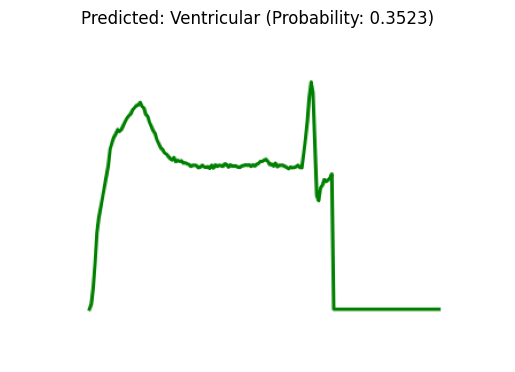

Final Prediction: Ventricular (Probability: 0.3523)


In [ ]:
from google.colab import files
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

# Class label mapping
class_label_mapping = {
    'N': 'Normal',
    'S': 'Supraventricular',
    'V': 'Ventricular',
    'F': 'Fibrillation',
    'Q': 'Premature Contractions',
    'M': 'Myocardial'
}

# Class labels (ensure this matches the model's output classes)
class_labels = ['F', 'M', 'N', 'Q', 'S', 'V']

print("Please upload an ECG image")
uploaded = files.upload()

# Get the uploaded image path
img_path = next(iter(uploaded))

def preprocess_image(img_path, img_size=(224, 224)):
    """ Preprocess the image: resize, normalize, and adapt shape """
    img = cv2.imread(img_path)  # Read in original format (BGR)
    img = cv2.resize(img, img_size)  # Resize to target size
    img = img / 255.0  # Normalize pixel values to range [0, 1]

    # Ensure the image has the correct shape (batch_size, height, width, channels)
    img = np.expand_dims(img, axis=0)  # Add batch dimension (1, 224, 224, 3)

    return img

# Preprocess the uploaded image
processed_image = preprocess_image(img_path)

# Load the pre-trained model
model_path = "/content/mobilenetv2_ecg_final.keras"
model = tf.keras.models.load_model(model_path)

# Print model summary to inspect the layers
model.summary()

# Make a prediction
predictions = model.predict(processed_image)

# Get predicted probabilities
predicted_probabilities = tf.nn.softmax(predictions[0]).numpy()

# Get predicted class index and corresponding probability
predicted_class_index = np.argmax(predicted_probabilities)
predicted_class_probability = predicted_probabilities[predicted_class_index]

# Print probabilities for each class
for i, label in enumerate(class_labels):
    print(f"{label}: {predicted_probabilities[i]:.4f}")

# Get predicted class code & name
predicted_class_code = class_labels[predicted_class_index]
predicted_class_name = class_label_mapping.get(predicted_class_code, "Unknown")

# Display the image with prediction
img = cv2.imread(img_path)  # Read in original format (BGR)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Display in correct color format
plt.title(f"Predicted: {predicted_class_name} (Probability: {predicted_class_probability:.4f})")
plt.axis('off')
plt.show()

# Print final prediction
print(f"Final Prediction: {predicted_class_name} (Probability: {predicted_class_probability:.4f})")


In [ ]:
# Display class indices
class_indices = {idx: label for idx, label in enumerate(class_labels)}
print("Class Indices Mapping:")
for idx, label in class_indices.items():
    print(f"{idx}: {label}")


Class Indices Mapping:
0: F
1: M
2: N
3: Q
4: S
5: V
